# Тестовое на AI_разработчик

## Задание

Создайте модель, обрабатывающую фрагмент текста и определяющую
какой вид продукции в нём содержится.

Выполненное задание пришлите ссылкой на Google Collab.
Датасет поделите на 80% / 20% - обучающая/тестовая выборки.

Используйте библиотеку PyTorch

Виды продукции (брать только виды продукции, для которых в датасете есть не менее **500 примеров**):

* Баранина
* Ягнятина
* Индейка
* Говядина
* Свинина
* Кура
* Цыплено
* Гусь
* Буйволятина
* Оленина
* Конина
* Телятина
* Кролик
* Утка
* Куропатка
* Перепел
* Глухарь
* Страус
* Заяц
* Кенгуру
* Изюбр
* Кабан
* Коза
* Косуля
* Лось
* Марал
* Медвежатина
* Бобер
* Цесарка
* Нутрия
* Рябчик
* Тетерев
* Фазан
* Як


**Примеры входных текстов и видов продукции:**\
Набор для бульона свиной Набор для бульона свиной, в наличии, 76р/кг. -> Свинина\
Мясо премиум Предлагаем котлетное мясо мраморной говядины. -> Говядина\
спинка цб -> Цыпленок


**Проверьте вашу модель на образцах:**\
Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20)\
Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.\
Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:\
Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.\

In [ ]:
# если ошибка ansi на gpu
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install spacy
!python -m spacy download ru_core_news_sm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-06-01 11:28:52.002204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 11:28:53.970390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-01 11:28:57.890754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 11:28:57.891307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node rea

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import spacy
import string

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import ru_core_news_sm
nlp = ru_core_news_sm.load()

pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)


In [ ]:
df = pd.read_csv('https://axe.inline-ltd.ru/data/meatinfo.csv', sep=';')

In [ ]:
df.head()

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина


In [ ]:
df[df.duplicated(subset=['text'])]

,text,mtype
5689,"Говядина 1 кат. П/т охл коровы В наличие, Россия , можно Беларусия, опт 207₽ с НДС , отгрузка г. Краснодар , возмож...",Говядина
7705,Выгодное Предложение! Курица Цб 82р/кг Наша компания ООО “Деловой Партнер” Предлагает вам Курицу ЦБ ГОСТ От 82 руб/к...,Кура
15236,печень говяжья,Говядина
17271,"Реализуем охлаждённое мясо свинины Торговый дом ""МЯСНОВ ТРЕЙД"" реализует охлаждённое мясо оптом от 16 тонн. Производ...",Свинина


In [ ]:
df['mtype'].value_counts()

Говядина                                                                                   8422
Свинина                                                                                    3050
Кура                                                                                       1571
Индейка                                                                                    1337
Баранина                                                                                   1116
Цыпленок                                                                                    942
Кролик                                                                                      334
Утка                                                                                        195
Оленина                                                                                     193
Конина                                                                                      176
Гусь                                    

In [ ]:
# По условию отбросим значения встречающиеся реже 500 раз, заодно удалим ошибки разметки
counts = df['mtype'].value_counts()
selected_features = counts[counts > 500].keys()
df = df.query('mtype in @selected_features')

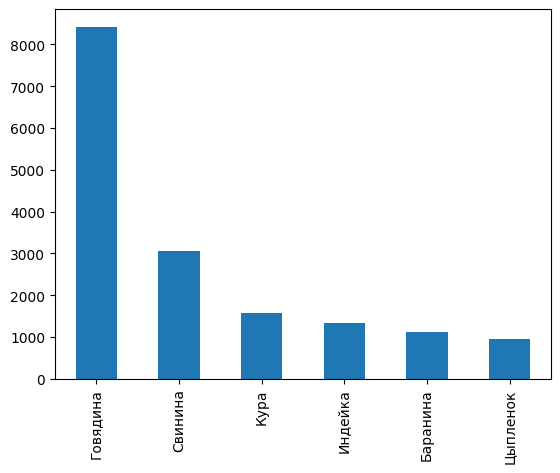

In [ ]:
df['mtype'].value_counts().plot(kind='bar');

In [ ]:
df[df['text'].str.contains('@')]['text'].count()

32

In [ ]:
df[df['text'].str.contains('http')]['text'].count()

23

In [ ]:
df = df.reset_index(drop=True)
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny') # tokenizer rubert-tiny
MAX_LEN = 256 # test 128, 320... comb with adam step and batch

category_list = df['mtype'].unique().tolist() # target str to int
label_map = {category_list[i]: i for i in range(len(category_list))}

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
def text_clean(text):
    '''
    Очистка текста от спец. символов, цифр, англ. букв
    '''
    text = re.sub(r'\b[A-Z]+\b', '', text)
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub(r'[^а-я]', ' ', text)
    text = re.sub(r"^\s+", "", text)
    text = re.sub(r"\s+$", "", text)
    text = re.sub(" +", " ", text)
    return text

In [ ]:
class MyDataset(Dataset):
    '''преобразование данных для обучения модели'''
    def __init__(self, data, tokenizer, max_len, label_map):
        self.tokenizer = tokenizer
        self.sentences = [self.preprocess_text(text) for text in data['text']]
        self.labels = data['mtype'].apply(lambda x: label_map[x])
        self.max_len = max_len

    def preprocess_text(self, text):
        text = text_clean(text)
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        return ' '.join(tokens)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        encoded_dict = self.tokenizer.encode_plus(
            self.sentences[index],
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {'input_ids': encoded_dict['input_ids'].flatten(),
                'attention_mask': encoded_dict['attention_mask'].flatten(),
                'labels': torch.tensor(self.labels[index])}

In [ ]:
train_dataset = MyDataset(train_df, tokenizer, MAX_LEN, label_map)
test_dataset = MyDataset(test_df, tokenizer, MAX_LEN, label_map)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True) # 16 small, 24 and 32 apprx, 64 bad qual
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)

model = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny', num_labels=len(category_list))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss() # mb add imbalance correction with class_weights or SMOTE

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # mb for test

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [ ]:
for epoch in range(4): # 5 and 6 for test with < adam step
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs = {k: v.to(device) for k, v in data.items()}
        optimizer.zero_grad()
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=inputs['labels'])
        loss = criterion(outputs.logits, inputs['labels'])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        #if i % 100 == 99:
        if i % 100 == 99:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 1, Batch:   100, Loss: 1.010
Epoch: 1, Batch:   200, Loss: 0.271
Epoch: 1, Batch:   300, Loss: 0.167
Epoch: 1, Batch:   400, Loss: 0.130
Epoch: 1, Batch:   500, Loss: 0.129
Epoch: 2, Batch:   100, Loss: 0.106
Epoch: 2, Batch:   200, Loss: 0.110
Epoch: 2, Batch:   300, Loss: 0.101
Epoch: 2, Batch:   400, Loss: 0.107
Epoch: 2, Batch:   500, Loss: 0.076
Epoch: 3, Batch:   100, Loss: 0.085
Epoch: 3, Batch:   200, Loss: 0.091
Epoch: 3, Batch:   300, Loss: 0.085
Epoch: 3, Batch:   400, Loss: 0.083
Epoch: 3, Batch:   500, Loss: 0.093
Epoch: 4, Batch:   100, Loss: 0.084
Epoch: 4, Batch:   200, Loss: 0.082
Epoch: 4, Batch:   300, Loss: 0.073
Epoch: 4, Batch:   400, Loss: 0.070
Epoch: 4, Batch:   500, Loss: 0.070


In [ ]:
# test
model.eval()
total_correct = 0
total_samples = 0
for data in test_loader:
    inputs = {k: v.to(device) for k, v in data.items()}
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    _, predicted = torch.max(outputs.logits, 1)
    total_samples += inputs['labels'].shape[0]
    total_correct += (predicted == inputs['labels']).sum().item()

print('Accuracy on test set: %d %%' % (100 * total_correct / total_samples)) # mb better f1 with matrix

# save model
torch.save(model.state_dict(), 'model.pth')

Accuracy on test set: 96 %


Проверка модели на заданных образцах

In [ ]:
def predict_one_sent(test_text):
    processed_text = text_clean(test_text)
    encoded_dict = tokenizer.encode_plus(
                processed_text,
                add_special_tokens=True,
                max_length=MAX_LEN,
                #pad_to_max_length=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    with torch.no_grad():
        model.eval()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_label = torch.argmax(outputs.logits).item()
    predicted_category = category_list[predicted_label]
    print("Предсказанная категория: ", predicted_category)

In [ ]:
test_text_1 = "Говядина блочная 2 сорт в наличии ООО \"АгроСоюз\" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону."
test_text_2 = "Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:"
test_text_3 = "Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем."

In [ ]:
predict_one_sent(test_text_1)
predict_one_sent(test_text_2)
predict_one_sent(test_text_3)

Предсказанная категория:  Говядина
Предсказанная категория:  Кура
Предсказанная категория:  Говядина
